# Домашнее задание №4.
Основы машинного обучения. А.Шестаков  
Группа ML-11. __Студент - Усцов Артем Алексеевич__

Правила:

* Работоспособность будет проверяться в коллабе. Это значит, что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


# Part 0. Service function declaration

Connecting all the libraries necessary for work and declaring functions

In [4]:
# Для функционирования watermark - раскомментируйте строку ниже, либо установите библиотеку в консоли вручную
!pip install watermark
%load_ext watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [5]:
%watermark -v -m -p numpy,scipy,matplotlib,pandas,sklearn,nltk,codecs -g

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy     : 1.21.6
scipy     : 1.4.1
matplotlib: 3.2.2
pandas    : 1.3.5
sklearn   : 0.0
nltk      : 3.2.5
codecs    : unknown

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: 



In [6]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.148
BogoMIPS:            4400.29
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

%matplotlib inline

In [8]:
# For compatibility with future Python versions
from __future__ import division

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Main system library importing
import os
import sys


# Main statistical library importing
from scipy import stats as sts
import statsmodels.api as sm
from itertools import product
from collections import Counter

# Main visual library importing
# Standard visualize
import matplotlib.image as pltimg
import matplotlib.cm as cm
from matplotlib import pylab as plt

# To create pipeline functions
from joblib import dump, load

# Normilizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Dimension decreasers
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.random_projection import SparseRandomProjection

# Clusteres
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# Clustering metrics
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

In [9]:
os.getcwd()

'/content'

# Part 1. Задача про датчики на руках
В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [10]:
# Загружаем данные сенсоров
df_database = pd.read_csv("https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/sign_database.csv")

# Загружаем метки классов
sign_classes = pd.read_csv('https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [11]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

x_l       x_r       y_l       y_r       z_l       z_r    roll_l  \
0 -0.097816 -0.127761 -0.029051  0.537977  0.249162  0.508908  0.239445   
1 -0.102460 -0.126734 -0.029230  0.537758  0.246477  0.507236  0.240116   
2 -0.103085 -0.125618 -0.028605  0.537464  0.244890  0.507273  0.234753   
3 -0.102639 -0.126020 -0.028873  0.537306  0.244890  0.507639  0.232072   
4 -0.105139 -0.127538 -0.028917  0.537513  0.244816  0.506626  0.234083   

     roll_r  pitch_l   pitch_r  ...  forefinger_l  forefinger_r  middle_l  \
0  0.039819      0.0  0.007009  ...      0.369149      0.381857  0.570995   
1  0.039057      0.0  0.007009  ...      0.326618      0.402561  0.595044   
2  0.039057      0.0  0.007494  ...      0.295135      0.436131  0.639491   
3  0.026864      0.0  0.009431  ...      0.239311      0.521583  0.723905   
4  0.026864      0.0  0.008947  ...      0.199478      0.675103  0.786566   

   middle_r  ring_l    ring_r  little_l  little_r  id  time  
0  0.343431     0.0  0.000000       0.0  0.133088   0     0  
1  0.291571     0.0  0.000000       0.0  0.084865   0     1  
2  0.242470     0.0  0.000000       0.0  0.026230   0     2  
3  0.224264     0.0  0.014668       0.0  0.015033   0     3  
4  0.235298     0.0  0.010813       0.0  0.000815   0     4  

[5 rows x 24 columns]

In [12]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

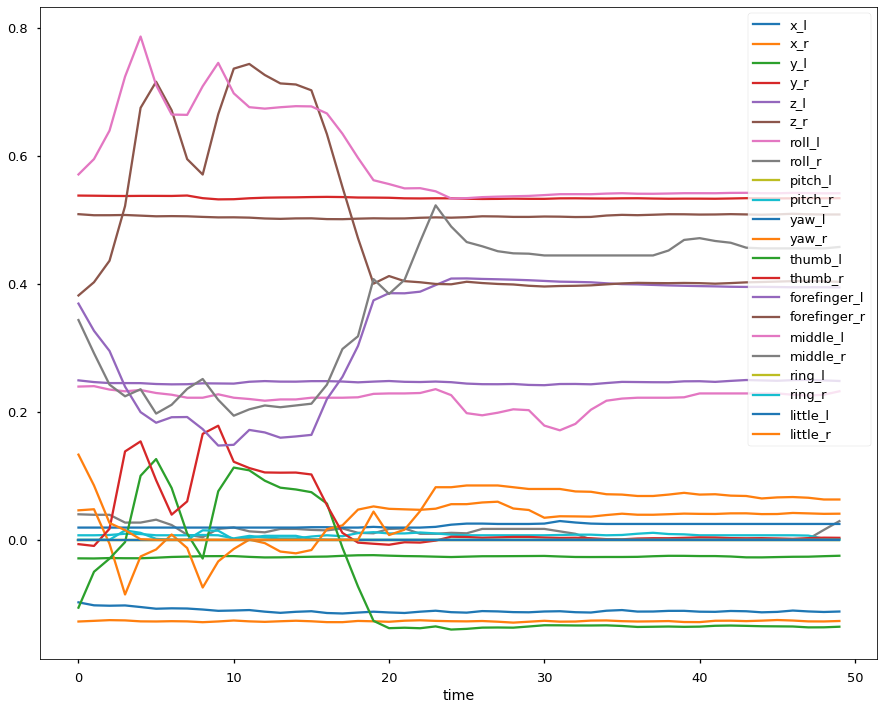

In [13]:
sign0.plot(figsize=(15,12))

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Part 1. 1 Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [16]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

--2022-04-21 17:47:36--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2022-04-21 17:47:37--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0dafe4d1288e085a7a6600c0c3.dl.dropboxusercontent.com/cd/0/inline/Bj1kN-SfdUxBvEqv6DnMRqeG5jRmgrIW8tL3TYOKGB1Pr8pe2g6wZBSYRyGxEssaLFKeoFJGBfM08ZsPBA1lEFf3CSWUqGLGVk5CK5SYBiZZq0UsP-Yd4T2Ph4AM7YsA6QAl_JUb0kdh73ghnshTxGKSSBoYOMd_C_2t1PbeSTznBg/file# [following]
--2022-04-21 17:47:37--  https://uc0dafe4d1288e085a7a6600c0c3.dl.dropboxusercontent.com/cd/0/inline/Bj1kN-SfdUxBvEq

In [17]:
sign_features_filtered.shape

(2565, 11517)

In [18]:
sign_features_filtered.head()

Unnamed: 0  ring_r__maximum  \
0           0         0.014764   
1           1         0.017579   
2           2         0.043917   
3           3         0.000000   
4           4         0.061037   

   ring_r__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"  \
0                                           0.998626                       
1                                           0.017579                       
2                                           0.043917                       
3                                           0.000000                       
4                                           0.061037                       

   ring_r__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"  \
0                                           0.000174                    
1                                           0.000180                    
2                                           0.000737                    
3                                           0.000000                    
4                                           0.001453                    

   ring_r__fft_coefficient__attr_"abs"__coeff_2  \
0                                      0.047854   
1                                      0.045183   
2                                      0.059952   
3                                      0.000000   
4                                      0.402618   

   ring_r__linear_trend__attr_"stderr"  ring_r__quantile__q_0.9  \
0                             0.000034                 0.006166   
1                             0.000027                 0.003599   
2                             0.000092                 0.028252   
3                             0.000000                 0.000000   
4                             0.000127                 0.047034   

   ring_r__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"  \
0                                           0.000423                   
1                                           0.000397                   
2                                           0.001034                   
3                                           0.000000                   
4                                           0.001777                   

   ring_r__variance  ring_r__standard_deviation  ...  \
0          0.000015                    0.003881  ...   
1          0.000012                    0.003399  ...   
2          0.000142                    0.011921  ...   
3          0.000000                    0.000000  ...   
4          0.000314                    0.017728  ...   

   forefinger_l__large_standard_deviation__r_0.15000000000000002  \
0                                                1.0               
1                                                1.0               
2                                                1.0               
3                                                1.0               
4                                                1.0               

   little_r__symmetry_looking__r_0.15000000000000002  \
0                                                1.0   
1                                                0.0   
2                                                1.0   
3                                                0.0   
4                                                0.0   

   z_l__symmetry_looking__r_0.35000000000000003  \
0                                           1.0   
1                                           1.0   
2                                           1.0   
3                                           1.0   
4                                           1.0   

   roll_r__large_standard_deviation__r_0.25  \
0                                       1.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       0.0   

   roll_r__large_standard_deviation__r_0.45  \
0                                      

## Part 1.2 Базовая модель

В результате у нас получилось очень много признаков __(11517)__, давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [20]:
sign_classes["class"].values

array(['alive', 'alive', 'alive', ..., 'zero', 'zero', 'zero'],
      dtype=object)

In [21]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes["class"].values

In [22]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [23]:
base_cv_scores.mean()

0.9196881091617932

## Part 1.3 Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

Создадим бейзлайн c уменьшением размерности при помощи метода главных компонент.
Основанием для его использования будет являться наличие большого количества признаков.

#### (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений

In [24]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10, random_state=42, svd_solver='randomized')),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [25]:
# Достигнутое качество
base_cv_scores.mean()

0.7048732943469787

#### (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 

Заведем функцию зависимости качества модели от количества компонент

In [64]:
# Так как зависимость количества главных компонент и качества модели монотонно неубывающая, то поиск можно осущетвить за log(n), где n-количество компонент
# Осуществим алгоритм бинарного поиска
def find_min_num_of_components(X, y, max_num_of_components, required_model_score):
    # настройки модели
    base_score = 0.0
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # реализация бинарного поиска
    array = [i for i in range(max_num_of_components+1)]
    mid = 0
    start = 0
    end = len(array)
    step = 0

    # запас для подсчета разницы base_score и required_model_score
    epsilon = 0.01

    while (start < end):
        step = step + 1
        mid = (start + end) // 2
        print(f"Шаг {step}")
        print(f"Правая граница массива {start}")
        print(f"Левая граница массива {end}")
        print(f"Индекс mid = {mid} и значение num_of_components = {array[mid]}")
        base_model = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=array[mid], random_state=42, svd_solver='randomized')),
            ('clf', KNeighborsClassifier(n_neighbors=9))
        ])
        base_score = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy').mean()
        print(f"Значение base_score = {base_score}\n")

        if abs(required_model_score - base_score) >= epsilon:
            print(f"Реализация нашла нужный элемент за {step} шагов")
            return array[mid]
            
        else:
            start = mid + 1
    print(f"!Реализация не нашла нужный элемент. Увеличьте max_num_of_components!")
    return -1

In [65]:
num_of_components = find_min_num_of_components(X=X, y=y, max_num_of_components=150, required_model_score=0.90)

Шаг 1
Правая граница массива 0
Левая граница массива 151
Индекс mid = 75 и значение num_of_components = 75
Значение base_score = 0.9029239766081872

Шаг 2
Правая граница массива 76
Левая граница массива 151
Индекс mid = 113 и значение num_of_components = 113
Значение base_score = 0.9161793372319688

Реализация нашла нужный элемент за 2 шагов


In [66]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=num_of_components, random_state=42, svd_solver='randomized')),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [67]:
# Достигнутое качество
base_cv_scores.mean()

0.904093567251462

In [68]:
# Лучшая модель
pipeline = base_model.fit(X, y)

#### (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

In [69]:
print(f"Объясненная доля дисперсии данных при минимальном количестве компонент:\
      {round(np.cumsum(pipeline[1].explained_variance_ratio_)[-1] * 100, 3)}%")

Объясненная доля дисперсии данных при минимальном количестве компонент:      66.939%


# Part 2. Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [70]:
df = pd.read_csv('https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/news.csv', encoding='utf8')
df.head()

text        date  \
0   В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...  2017-01-10   
1   Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...  2017-01-10   
2   Аргументы и Факты (aif.ru), Москва, 14 января...  2017-01-10   
3   Google Новости ТОП, Москва, 14 января 2017 АК...  2017-01-10   
4   Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...  2017-01-10   

                                event                   class  
0  Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
1  Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
2  Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
3  Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
4  Передача РПЦ Исаакиевского собора   Внутренняя политика РФ

In [71]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

In [72]:
print(f"Количество реальных кластеров в данных: {len(df.loc[:, 'class'].unique())}")

Количество реальных кластеров в данных: 11


Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубриками с помощью ARI

## Part 3.1 Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [73]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [74]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [75]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [76]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [77]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2022-04-21 18:35:21--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.243, 5.45.205.242, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-mskm907.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-04-21 18:35:21--  https://cachev2-mskm907.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm907.cdn.yandex.net (cachev2-mskm907.cdn.yandex.net)... 5.45.220.118, 2a02:6b8:0:2002::918
Connecting to cachev2-mskm907.cdn.yandex.net (cachev2-mskm907.cdn.yandex.net)|5.45.220.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linu

In [79]:
%%time 
from pymystem3 import Mystem


# Нормилизуем текст при помощи лемматизации
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 6.45 s, sys: 282 ms, total: 6.73 s
Wall time: 42.2 s


In [80]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Удалим стоп-слова
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [81]:
# Первая статья после предобработки
df.text[0]

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

In [82]:
df

text        date  \
0     петербург проходить митинг против передача иса...  2017-01-10   
1     москва январь ситуация передача исаакиевский с...  2017-01-10   
2     аргумент факт москва январь оппозиция проводит...  2017-01-10   
3     новость топ москва январь акция против передач...  2017-01-10   
4     газета москва январь московский патриархия про...  2017-01-10   
...                                                 ...         ...   
1925  москва сентябрь кандидат депутат москва покуса...  2017-09-10   
1926  москва сентябрь избирком оценивать явка выборы...  2017-09-10   
1927  москва сентябрь кандидат столичный депутат пож...  2017-09-10   
1928  москва сентябрь медведев припоминать избранный...  2017-09-10   
1929  москва сентябрь жириновский призывать перенест...  2017-09-10   

                                   event                   class  
0     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
1     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
2     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
3     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
4     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ  
...                                  ...                     ...  
1925             Единый день голосования  Внутренняя политика РФ  
1926             Единый день голосования  Внутренняя политика РФ  
1927             Единый день голосования  Внутренняя политика РФ  
1928             Единый день голосования  Внутренняя политика РФ  
1929             Единый день голосования  Внутренняя политика РФ  

[1930 rows x 4 columns]

## Part 3.2 Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [83]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [84]:
texts = df.text.values
texts

array(['петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор

In [85]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    data_tfidf = tfidf_vectorizer.fit_transform(data)

    return data_tfidf, tfidf_vectorizer

In [86]:
# Возвращает значения - важности каждого документа внутри всего корпуса
texts_tfidf, tfidf_vectorizer = tfidf(texts)
texts_tfidf.data

array([0.0514778 , 0.05942121, 0.03234423, ..., 0.11931254, 0.07489714,
       0.02950725])

In [87]:
texts_tfidf.shape

(1930, 22682)

In [88]:
from sklearn.metrics import pairwise_distances
S = pairwise_distances(texts_tfidf, metric="cosine")
S

array([[0.        , 0.44004097, 0.38605142, ..., 0.9439901 , 0.94454202,
        0.9502331 ],
       [0.44004097, 0.        , 0.48576746, ..., 0.98777003, 0.96716568,
        0.97674828],
       [0.38605142, 0.48576746, 0.        , ..., 0.92659382, 0.9502416 ,
        0.93057278],
       ...,
       [0.9439901 , 0.98777003, 0.92659382, ..., 0.        , 0.74516875,
        0.81105658],
       [0.94454202, 0.96716568, 0.9502416 , ..., 0.74516875, 0.        ,
        0.82172841],
       [0.9502331 , 0.97674828, 0.93057278, ..., 0.81105658, 0.82172841,
        0.        ]])

[[], []]

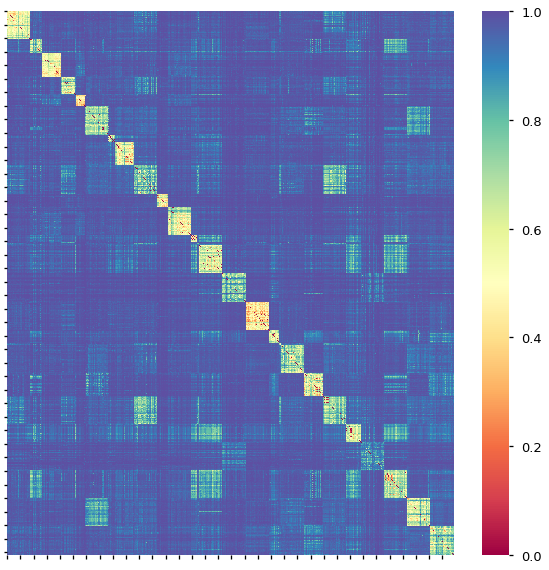

In [89]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль __главной__ диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## Part 3.2 DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [90]:
# Вначале попробуем понизить размерность и посмотреть как данные в принципе располагаются в двумерном пространстве

In [91]:
# До какой размерности понижаем
num_of_components = 2
# Зафиксируем состояние
random_state = 42

In [248]:
def decrease_dimension(data, num_of_components, random_state, model_preds=None):
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))

    # Рассмотрим несколько самых популярных методов понижения размерности
    obs = [
           # Метод случайных проекций - линейный
           SparseRandomProjection(num_of_components, random_state=random_state),
           # Метод главных компонент - линейный
           PCA(num_of_components, random_state=random_state),
           # Метод сингулярного разложения - линейный
           TruncatedSVD(num_of_components, random_state=random_state),
           # Метод t-stochastic neighbour embedding - нелинейный, с инициализацией pca
           TSNE(num_of_components, random_state=random_state, init="pca"),
           # Метод t-stochastic neighbour embedding - нелинейный, с инициализацией random
           TSNE(num_of_components, random_state=random_state, init="random"),
           # Метод многомерного шкалирования - нелинейный
           MDS(num_of_components, random_state=random_state)
          ]

    titles = ['Random projection', 'PCA', 'TruncatedSVD', 'TSNE(pca)', 'TSNE(random)', 'MDS']
    for i in range(len(obs)):
        points = obs[i].fit_transform(data)
        ax = axs[i % 2, i % 3]
        ax.scatter([j[0] for j in points], [j[1] for j in points], c=model_preds)
        ax.set_title(titles[i])

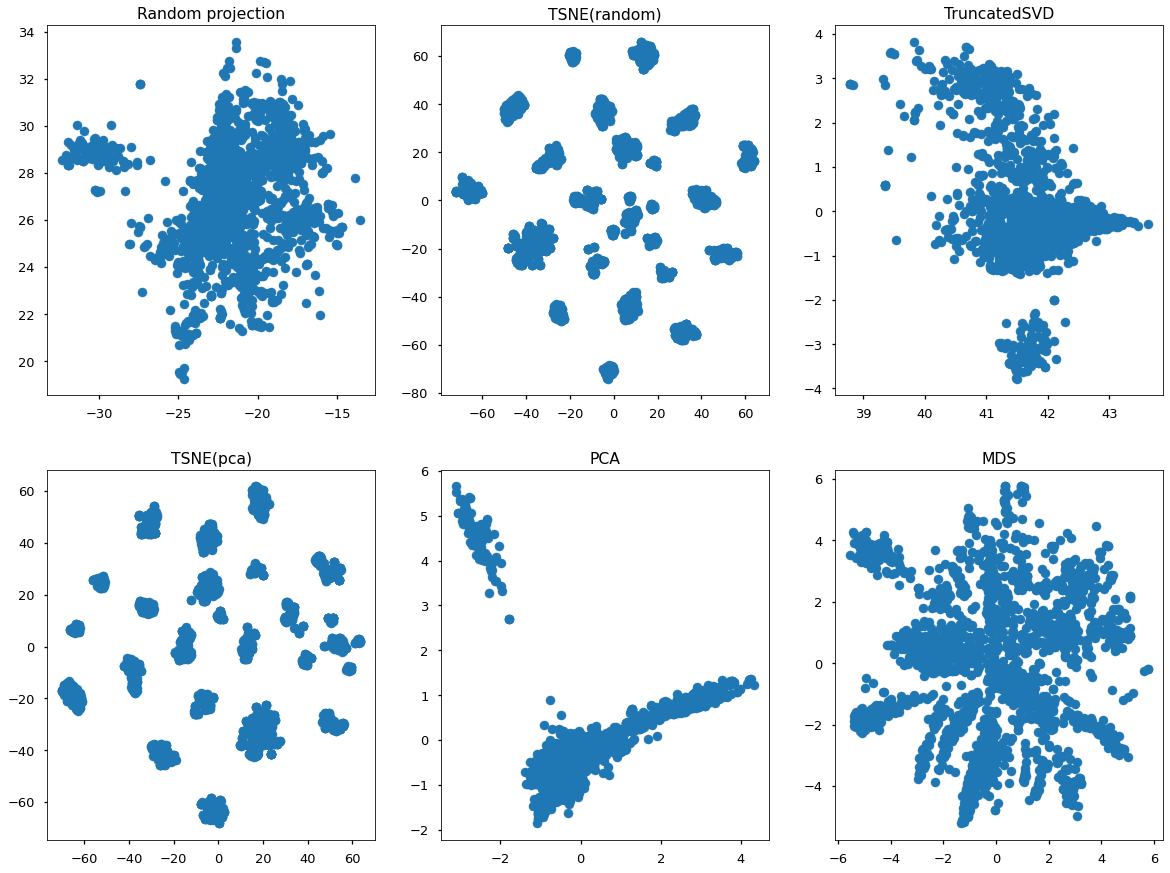

In [94]:
decrease_dimension(Sb, num_of_components, random_state)

Забавная картина наблюдается. TSNE считается одним из самых достоверных методов понижения размерности. Наблюдаем четкое разбиение на кластеры попарных расстояний

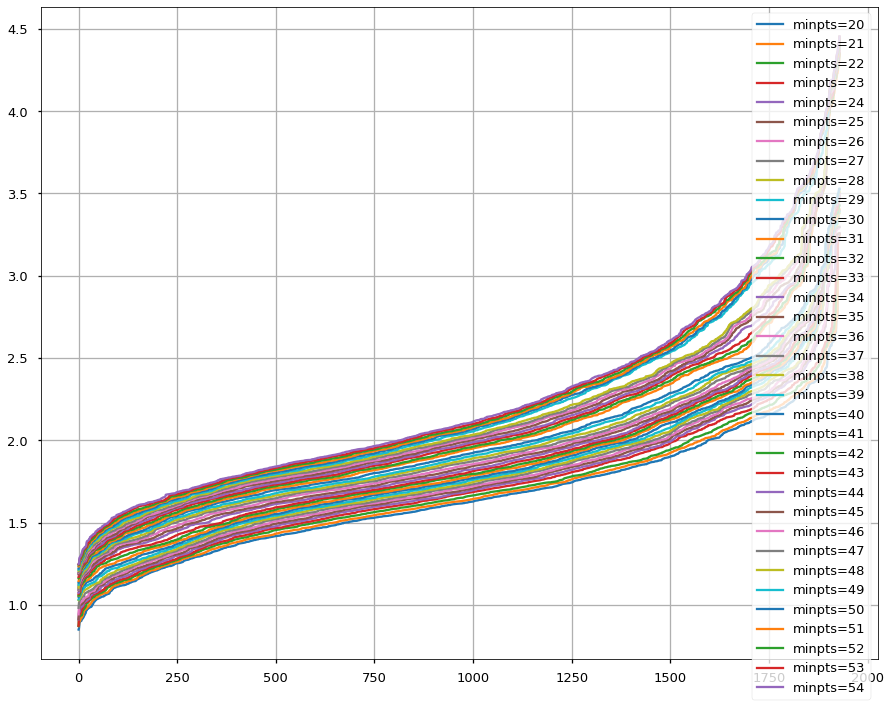

In [303]:
# Определим границы для eps
fig, ax = plt.subplots(figsize=(15,12))

for i in range(20, 55):
    nn = NearestNeighbors(n_neighbors=i)
    nn.fit(S)
    dist, _ = nn.kneighbors()
    dist_last = dist[:,-1]
    dist_last = np.sort(dist_last)
    plt.plot(dist_last, label='minpts=' + str(i))
plt.legend()
plt.grid()

In [342]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=2.15, 
                min_samples=52)
dbscan_preds = dbscan_model.fit_predict(S)
labels = dbscan_model.labels_

# Объекты с индексом -1 - есть индексы "выбросных" кластеров
print(np.unique(labels))
print(f"Количество получившихся кластеров в данных: {len(np.unique(labels))- 1}")
print(f"Количество реальных кластеров в данных: {len(df.loc[:, 'class'].unique())}\n")

print(pd.Series(labels).value_counts())
pd.crosstab(df.loc[:, 'class'], labels)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Количество получившихся кластеров в данных: 14
Количество реальных кластеров в данных: 11

-1     339
 5     211
 8     210
 3     195
 7     106
 0     100
 13    100
 9     100
 6      99
 10     99
 12     89
 1      84
 4      79
 2      63
 11     56
dtype: int64


col_0                                          -1    0    1    2    3    4   \
class                                                                         
Важные мировые события                         169    0   84    0    0    0   
Внутренняя политика РФ                          62  100    0    1    0    0   
Внутренняя политика РФ: оппозиция                3    0    0   62    0    0   
Внутренняя политика: культура                    0    0    0    0    0    0   
Международные отношения                         48    0    0    0    0    0   
Международные отношения: Криминальная хроника    3    0    0    0    0   79   
Проишествия  РФ                                  0    0    0    0    0    0   
Спорт                                            0    0    0    0    0    0   
Спорт                                            0    0    0    0    0    0   
Теракты                                          5    0    0    0  195    0   
Технологии                                      49    0    0    0    0    0   

col_0                                           5    6    7    8    9    10  \
class                                                                         
Важные мировые события                           0    0    6    1    0    0   
Внутренняя политика РФ                           0    0    0    3  100    0   
Внутренняя политика РФ: оппозиция              211    0    0    1    0    0   
Внутренняя политика: культура                    0   99    0    1    0    0   
Международные отношения                          0    0  100    2    0    0   
Международные отношения: Криминальная хроника    0    0    0    0    0    0   
Проишествия  РФ                                  0    0    0    1    0   99   
Спорт                                            0    0    0  100    0    0   
Спорт                                            0    0    0  101    0    0   
Теракты                                          0    0    0    0    0    0   
Технологии                                       0    0    0    0    0    0   

col_0                                           11   12   13  
class                                                         
Важные мировые события                          56   86    1  
Внутренняя политика РФ                           0    0   98  
Внутренняя политика РФ: оппозиция                0    0    0  
Внутренняя политика: культура                    0    0    0  
Международные отношения                          0    3    0  
Международные отношения: Криминальная хроника    0    0    0  
Проишествия  РФ                                  0    0    0  
Спорт                                            0    0    0  
Спорт                                            0    0    1  
Теракты                                          0    0    0  
Технологии                                       0    0    0

In [329]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

In [337]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df["class"])
true_labels = encoder.transform(df["class"])
np.unique(true_labels)
df["encoded_class"] = true_labels
df["predicted_class"] = labels

In [338]:
df

text        date  \
0     петербург проходить митинг против передача иса...  2017-01-10   
1     москва январь ситуация передача исаакиевский с...  2017-01-10   
2     аргумент факт москва январь оппозиция проводит...  2017-01-10   
3     новость топ москва январь акция против передач...  2017-01-10   
4     газета москва январь московский патриархия про...  2017-01-10   
...                                                 ...         ...   
1925  москва сентябрь кандидат депутат москва покуса...  2017-09-10   
1926  москва сентябрь избирком оценивать явка выборы...  2017-09-10   
1927  москва сентябрь кандидат столичный депутат пож...  2017-09-10   
1928  москва сентябрь медведев припоминать избранный...  2017-09-10   
1929  москва сентябрь жириновский призывать перенест...  2017-09-10   

                                   event                   class  \
0     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ   
1     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ   
2     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ   
3     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ   
4     Передача РПЦ Исаакиевского собора   Внутренняя политика РФ   
...                                  ...                     ...   
1925             Единый день голосования  Внутренняя политика РФ   
1926             Единый день голосования  Внутренняя политика РФ   
1927             Единый день голосования  Внутренняя политика РФ   
1928             Единый день голосования  Внутренняя политика РФ   
1929             Единый день голосования  Внутренняя политика РФ   

      encoded_class  predicted_class  
0                 1                0  
1                 1                0  
2                 1                0  
3                 1                0  
4                 1                0  
...             ...              ...  
1925              1               13  
1926              1               13  
1927              1               13  
1928              1               13  
1929              1               13  

[1930 rows x 6 columns]

In [345]:
# Проинтерпретируем кластеры
df[df["predicted_class"] == 0]["text"][0]

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

In [346]:
df[df["predicted_class"] == 0]["text"][15]

'иа москва январь исаакиевский собор проходить акция протест против передача рпц январь запланировать митинг житель санкт петербург собираться возле исаакиевский собор встреча депутат выражать протест против передача собор русский православный церковь сегодня январь сообщать местный сми сообщаться возле исаакиевский собор собираться около житель санкт петербург мероприятие проводить вид встреча депутат избиратель представлять коллективный депутатский запрос просьба отменять постановление передача собор ведение рпц акция проходить мирно встреча подписывать официальный заявка проведение митинг против передача исаакиевский собор рпц митинг состояться январь марсовый поле январь становиться известно власть петербург соглашаться передавать исаакиевский собор рпц сохранять музейный функция год смольный экономический соображение отвечать аналогичный требование отказ согласно распоряжение городской комитет имущественный отношение исаакий должный передавать рпц безвозмездный пользование срок го

In [349]:
df[df["predicted_class"] == 0]["text"][85]

'империя москва январь союз музей осуждать передача исаакиевский собор рпц творческий союз музейный работник санкт петербург расценивать передача исаакиевский собор русский православный церковь рпц ликвидация уникальный музей соответствующий заявление опубликовывать сайт союз музей россия ради уничтожаться музей уничтожаться сомнение работа любой музей работа коллектив понятно далеко сотрудник государственный учреждение культура готовый становиться работник религиозный организация говориться сообщение организация подчеркивать исаакиевский собор уникальный музей получать копейка бюджет текущий расход представитель союз называть собор памятник подвиг музейный работник год блокада ленинград трудный условие сохранять потомок изучать доверенный культурный наследие глава синодальный отдел московский патриархат взаимоотношение церковь общество сми владимир легойд очередь заверять рпц относиться сохранение собор ответственно прекрасно понимать простой храм хотя первый очередь храм памятник кул

In [361]:
df[df["predicted_class"] == 13]["text"][1003]

'коммерсант москва май германия проводить последний испытание автор александр быковский региональный выборы становиться тесто ангел меркель воскресение запад германия проходить выборы парламент самый населенный земля северный рейн вестфалия четыре месяц выборы бундестаг голосование становиться последний предвыборный тесто канцлер ангел меркель христианский демократический союз хдс особый значение земля представлять главный оппонент кандидат социал демократический партия германия сдпг мартин шульц родной регион сдпг традиционно прочный позиция дважды год партия проигрывать хдс местный выборы подробность кельн корреспондент ъ александр быковский день улица кельн легко расслышать русский речь проходить чемпионат мир хоккей российский сборная обыгрывать немец сегодня сталкиваться словак любой турист болельщик невольно знакомиться внутриполитический повестка выборы федеральный земля северный рейн вестфалия последний рубеж сентябрьский выборы бундестаг сила агитация политический партия жалет

In [358]:
df[df["predicted_class"] == 9]["text"][1033]

'турист скидываться рубль крым автор фаляхов рустем рубль сутки смочь взимать власть турист крым алтайский краснодарский ставропольский край соответствующий законопроект вносить госдума иметь шанс принятие сам турист называть сбор налог воздух правительство решать устраивать эксперимент турист госдума вносить законопроект проведение эксперимент развитие курортный инфраструктура предусматриваться проведение январь год декабрь год включительно эксперимент введение плата пользование курортный инфраструктура курортный сбор республика крым алтайский краснодарский ставропольский край говориться текст законопроект курортный инфраструктура пониматься совокупность объект лечебный оздоровительный социально культурный физкультурный спортивный рекреационный назначение расположенный территория иной слово новый налог вводиться главный курорт страна размер определяться региональный местный власть предполагаться размер курортный сбор составлять рубль сутки фактический пребывание объект размещение дифф

__В действительности тексты в лейблах 9, 0, 13 очень похожи между собой. Как будто бы прошло разделение по странам внутри текстов.__

In [363]:
df[df["predicted_class"] == 2]["text"][235]

'кроссовок медведева тяжелый артиллерия правда автор жвирблис андрей ролик фонд борьба коррупция димон набирать сутки миллион просмотр особенность работа фбк насколько доверять описание проходить расследование дмитрий медведев фото александр астафьев тасс видеоролик димон фонд борьба коррупция алексей навальный собирать сутки миллион просмотр общественность заинтересовываться деятельность благотворительный фонд дар время дмитрий медведев становиться президент называть дача медведев краснодарский утрише причастность фонд партия яблоко год написать брошюра черноморский дворец хозяин экологический активист краснодарский край протестовать против строительство развернутый заповедный зона собирать информация он рано конец х вскоре однокурсник дмитрий медведев илья елисеев фонд дар люксовый недвижимость разный регион становиться писать многий сми такой новый газета ведомость некоторый сетевой издание блогер такой андрей мальгин публикация пожалуй еженедельник собеседник причем публикация посл

In [364]:
df[df["predicted_class"] == 2]["text"][242]

'компромат москва март дмитрий медведев дарить однокурсник дмитрий медведев дарить однокурсник дача плес два усадьба рублевка усадьба мансурово резиденция псехако виноградник анапа тоскана особняк питер два яхта оригинал материал фото иллюстрация видео димон премьер министр дмитрий медведев создавать образ чиновник никто воспринимать всерьез самый одиозный высказывание вызывать общество скоро насмешка гнев он относиться снисхождение хотя кажется откровенный злодей сегодня рассказывать насколько заблуждаться дмитрий анатольевич медведев вовсе смешной чудак стоять подсмеиваться создатель глава огромный многоуровневый коррупционный схема руководитель править партия единый россия владеть недвижимость весь страна принадлежать огромный участок земля самый элитный район распоряжаться яхта квартира старинный особняк агрокомплекс винодельня россия рубеж имущество приобретать взятка олигарх кредит госбанк премьер министр доверенный человек создавать преступный схема основывать офшор часто бывать

In [366]:
df[df["predicted_class"] == 5]["text"][1464]

'политика москва июнь навальный арестовывать месяц призыв протест симоновский суд российский столица ночь арестовывать алексей навальный сутки ранее алексей навальный задерживать страда порядок призыв участие несанкционированный акция центр город являться повторный административный нарушение кроме оппозиционер вменять неповиновение сотрудник правоохранительный орган сообщать информационный агентство риа новость алексей навальный признавать виновный совершение административный правонарушение суд назначать наказание вид административный арест срок сутки говориться решение суд оглашенный ночь кроме срок арест навальный суд решать исчислять июнь верить протокол заседание алексей навальный осуждать нарушение организатор публичный мероприятие установленный порядок организация проведение собрание митинг демонстрация акция протест алексей навальный арест симоновский суд москва'

In [373]:
df[df["predicted_class"] == 5]["text"][600]

'коммерсант новость москва март алексей навальный получать сутки автор гробман екатерина оппозиционер признавать виновный организация митинг неповиновение полиция оппозиционный политик алексей навальный приговаривать административный арест сутки неповиновение полиция антикоррупционный акция москва март сам организация несанкционированный митинг политика выписывать штраф руб господин навальный вина признавать политолог сходиться мнение прошедший весь страна протест сыграть рука алексей навальный заявлять президентский амбиция тверской райсуд москва сегодня рассматривать дело отношение алексей навальный сначала судья алеся орехов признавать виновный организация призыв участие санкционировать власть митинг присуждать штраф руб время заседание оппозиционер предлагать суд допрашивать премьер министр дмитрий медведев называть настоящий организатор протестный митинг участник акция название мы димон требовать премьера отвечать обвинение коррупция повод становиться фильм расследование размещать

__А здесь кластер как будто разбился вновь на два. Про Медведева и Навального__

In [331]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
adjusted_rand_score(true_labels, labels)

0.5020421180980359

Проинтерпретируем полученные кластеры

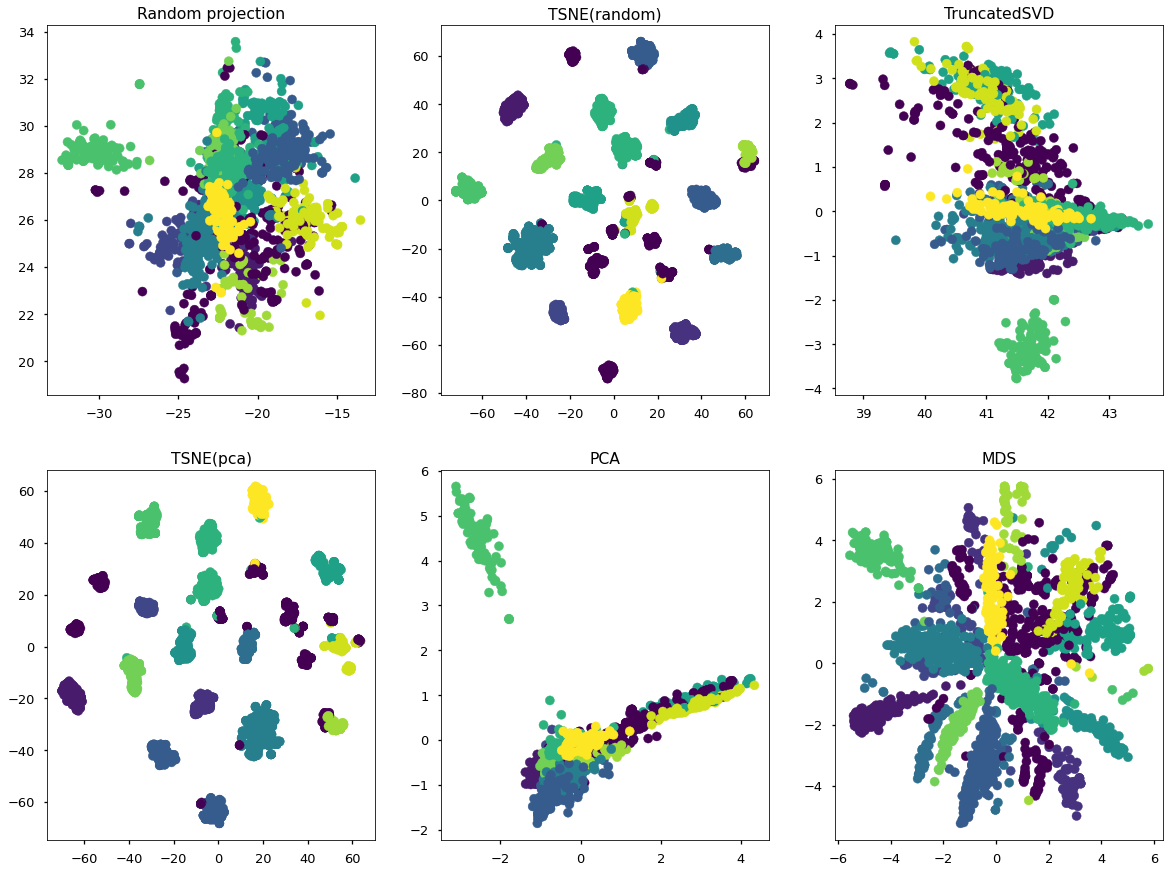

In [237]:
# Попробуем визуализировать разбиение на кластеры
decrease_dimension(S, num_of_components, random_state, dbscan_preds)

__Как итог, будем считать, что кластеризация получилась неудачной__:  
1) С учетом подбора minpts и epsilon вменяемый показатель ARI получается на 52 точках, однако при этом количество кластеров равняется 15, что противоречит 
фактическим 11
2) Согласно ARI успешно кластеризовать получилось только 50% пар признаков, что будем считать неудовлетворительным показателем.

## __ДОПОЛНИТЕЛЬНО : Попробуем рассмотреть данные под другим углом__
Подойдем к задаче разбития на кластеры, как будто бы у нас не было разметки

{1: 164.0,
 2: 155.0,
 3: 145.0,
 4: 138.0,
 5: 132.0,
 6: 125.0,
 7: 119.0,
 8: 112.0,
 9: 106.0,
 10: 101.0,
 11: 97.0,
 12: 94.0,
 13: 91.0,
 14: 86.0,
 15: 83.0,
 16: 80.0,
 17: 77.0,
 18: 74.0,
 19: 71.0,
 20: 69.0,
 21: 68.0,
 22: 67.0,
 23: 65.0,
 24: 65.0}

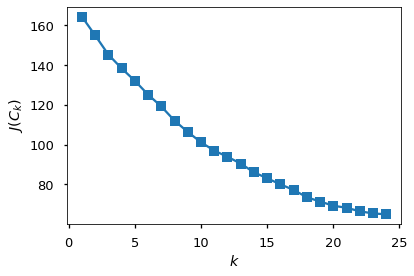

In [ ]:
# Попробуем оценить количество кластеров для метода KMeans. 
# Используем эвристику elbow-method, подбирать k будем исходя из падения критерия J(C) "не так сильно"
inertia = []
max_num_clusters = 25

for k in range(1, max_num_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(vals)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, max_num_clusters), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

{num: round(inrt, 0) for num, inrt in zip(range(1, max_num_clusters), inertia)}

Эвристика не дала точной оценки, но хочется сказать, что количество кластеров лежит в диапазоне от 10 до 13

In [249]:
def siluette_check(data,
                   n_clusters,
                   clusterer_name="KMeans",
                   random_state=42,
                   num_of_dimensions=2,
                   eps_=27,
                   min_samples_=2,
                  ):
    
    # Массив перебераемых значений количества кластеров
    range_n_clusters = [i for i in range(2, n_clusters + 1)]

    for n_clusters in range_n_clusters:
        # Создаем сабплот
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # 1ый график для критерия силуэт
        # По определению значение критерия лежит от -1 до 1. Примем субъективное ограничение от 0 до 1
        ax1.set_xlim([0, 1])
        # Добавим небольшое смещение для графика, чтобы было удобнее их различать
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Лейблы от конкретной модели кластеризации
        if clusterer_name == "KMeans":
            clusterer = KMeans(n_clusters=n_clusters, 
                               random_state=random_state)
        elif clusterer_name == "EM":
            clusterer = GaussianMixture(n_components=n_clusters, 
                                        covariance_type='diag', 
                                        random_state=random_state)
        elif clusterer_name == "DBSCAN":
            clusterer = DBSCAN(eps=eps_, 
                               min_samples=min_samples_)
        elif clusterer_name == "AGH":
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, 
                                                affinity='euclidean', 
                                                linkage='ward')
            
        cluster_labels = clusterer.fit_predict(data)

        # Подсчитаем среднее значение силэута для всей выборки при помощи silhouette_score
        # Это дает представление о плотности и разделении сформированных кластеров
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Подсчитаем значение силэута для выборки при помощи silhouette_samples
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # Понижение размерности для визуализации
        dimension_decreaser = TSNE(num_of_dimensions, 
                                   random_state=random_state, 
                                   init="random"
                                  )

        points = dimension_decreaser.fit_transform(data)

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            [j[0] for j in points], [j[1] for j in points], 
            marker="o", s=100, lw=0, c=colors, edgecolor="k"
        )

        ax2.set_title("The visualization of the clustered data with TSNE")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {clusterer_name} on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

In [250]:
def draw_counter_bar(model_preds):
    print(Counter(model_preds))

    fig, ax = plt.subplots(figsize=(5, 5))
    x = list(Counter(sorted(model_preds)).keys())
    y = list(Counter(sorted(model_preds)).values())
    ax.bar(x, y)

    plt.show()

In [240]:
# Инициализируем максимальное количество кластеров
num_of_clusters = 13

In [242]:
# Обучим простой KMeans и визуализируем
km_model = KMeans(n_clusters=num_of_clusters, random_state=random_state)
km_preds = km_model.fit_predict(S)

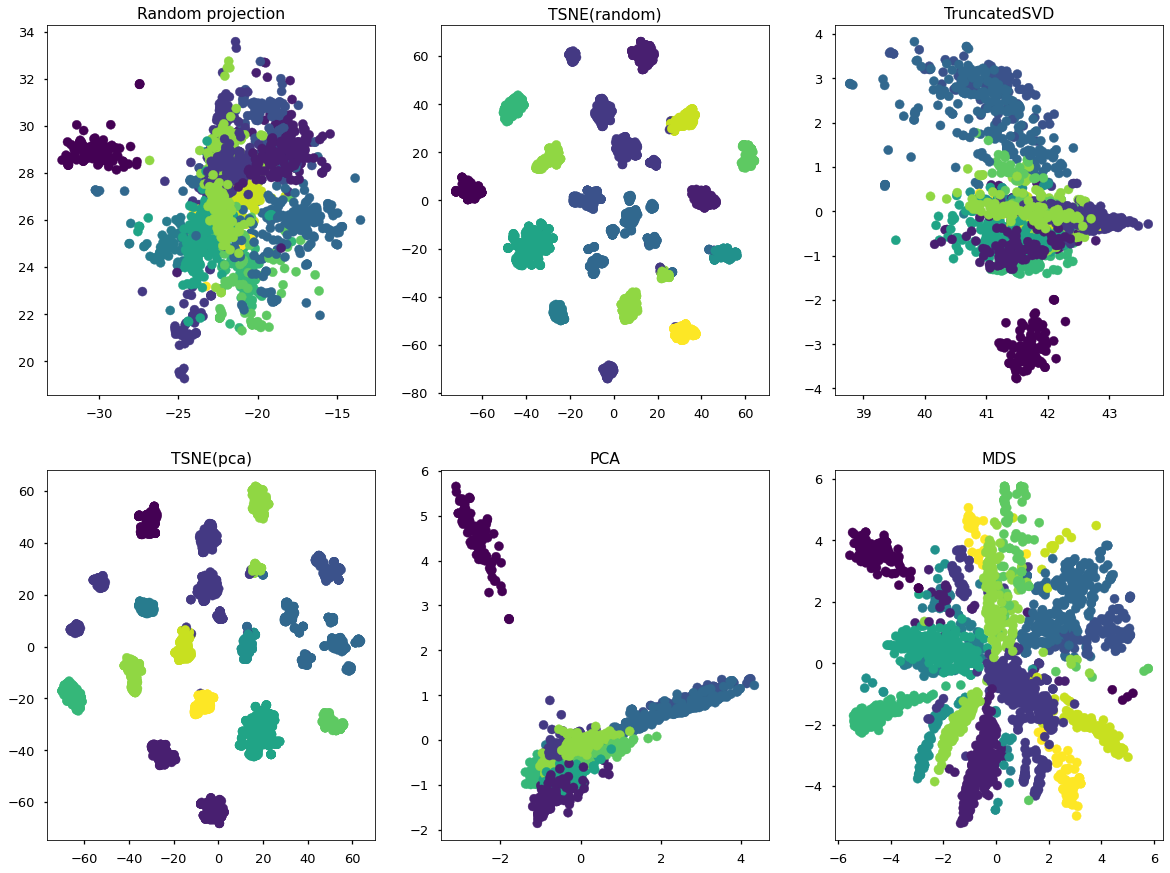

In [243]:

decrease_dimension(S, num_of_components, random_state, km_preds)

For n_clusters = 2 The average silhouette_score is : 0.1387374523405126
For n_clusters = 3 The average silhouette_score is : 0.1866722461684655
For n_clusters = 4 The average silhouette_score is : 0.1855933749138616
For n_clusters = 5 The average silhouette_score is : 0.25221603271775844
For n_clusters = 6 The average silhouette_score is : 0.2575572351489387
For n_clusters = 7 The average silhouette_score is : 0.29432953758868446
For n_clusters = 8 The average silhouette_score is : 0.306593056361958
For n_clusters = 9 The average silhouette_score is : 0.3268247632461663
For n_clusters = 10 The average silhouette_score is : 0.3561435483207882
For n_clusters = 11 The average silhouette_score is : 0.3746104348130008
For n_clusters = 12 The average silhouette_score is : 0.3733513644048824
For n_clusters = 13 The average silhouette_score is : 0.38632203290626765


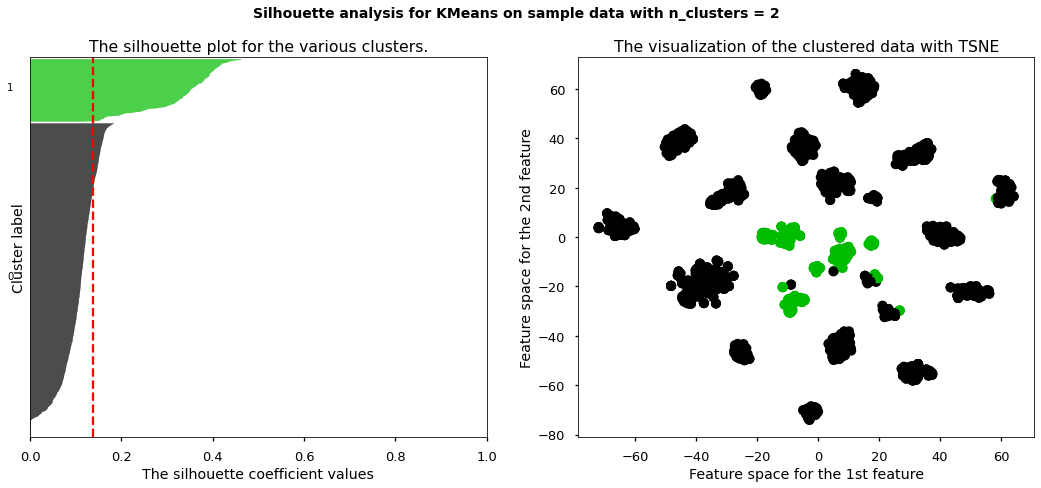

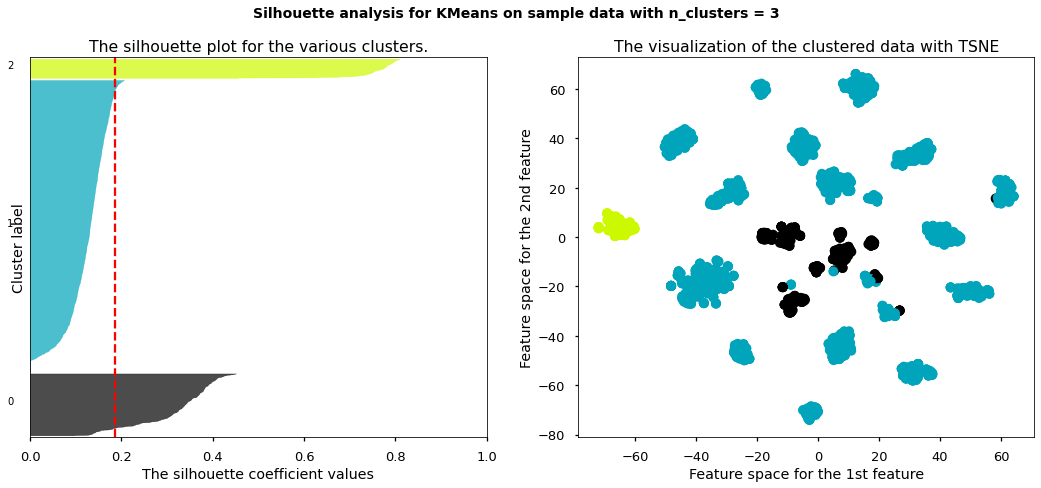

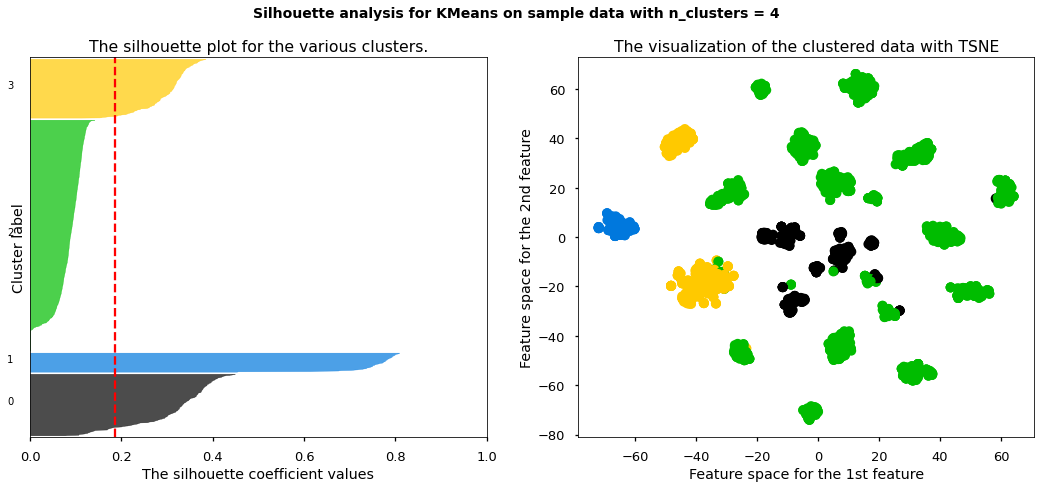

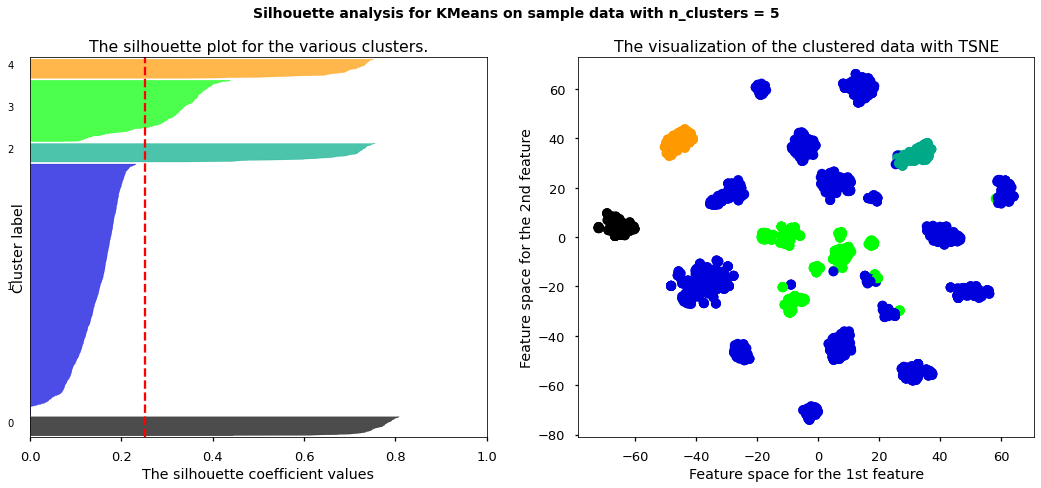

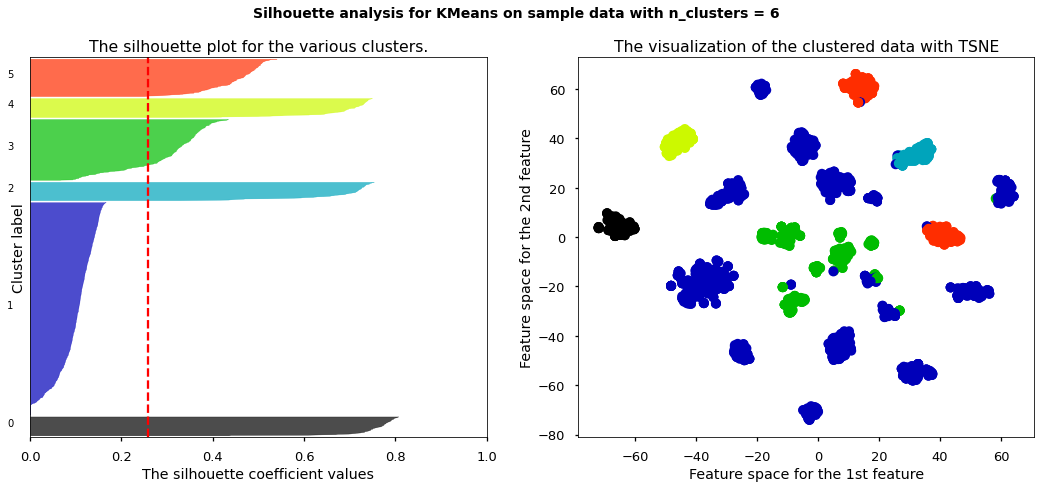

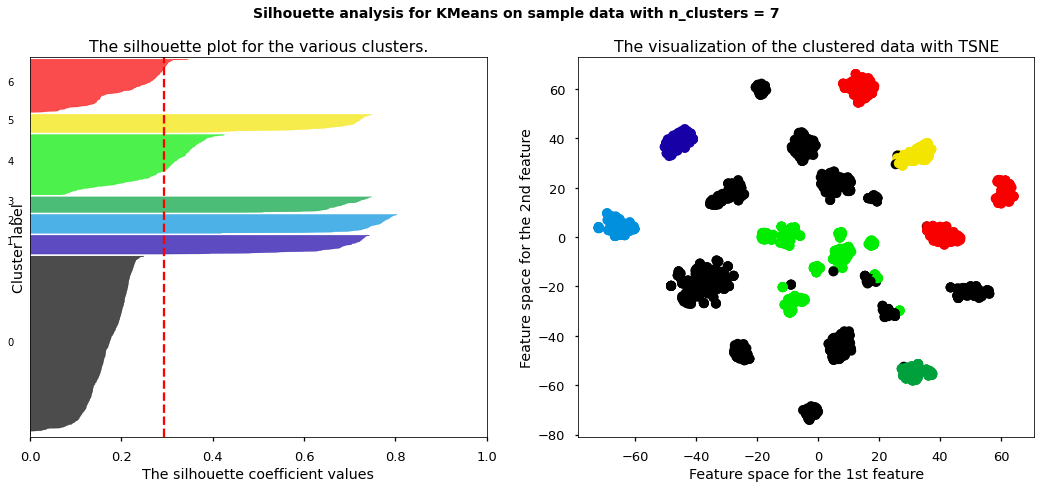

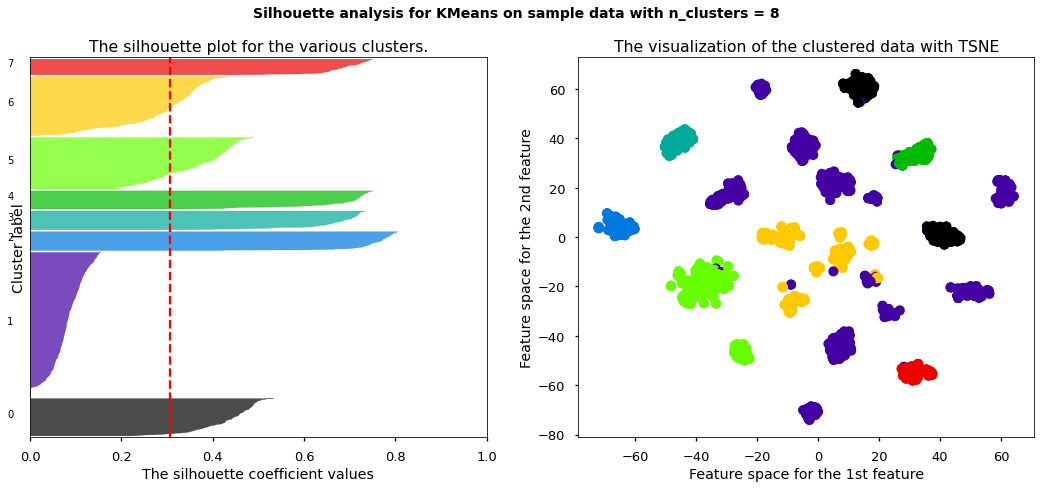

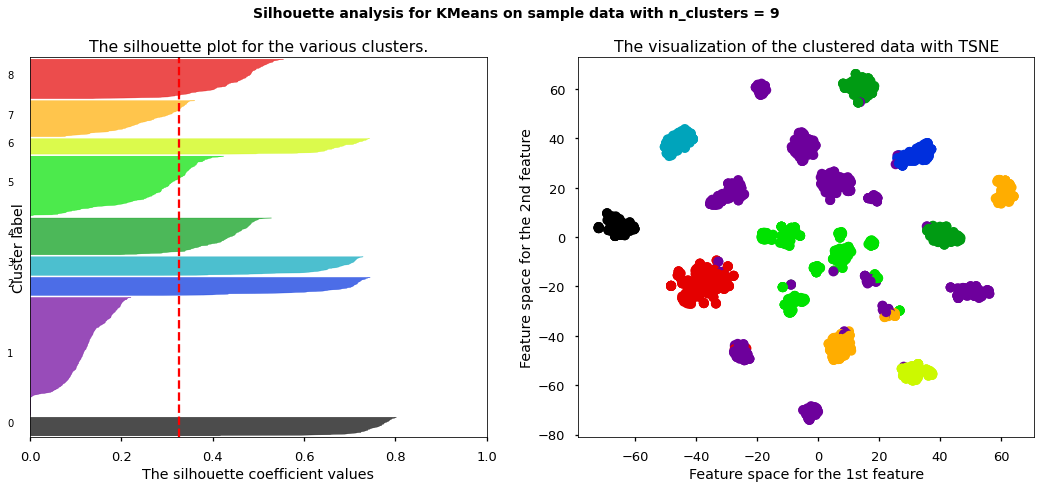

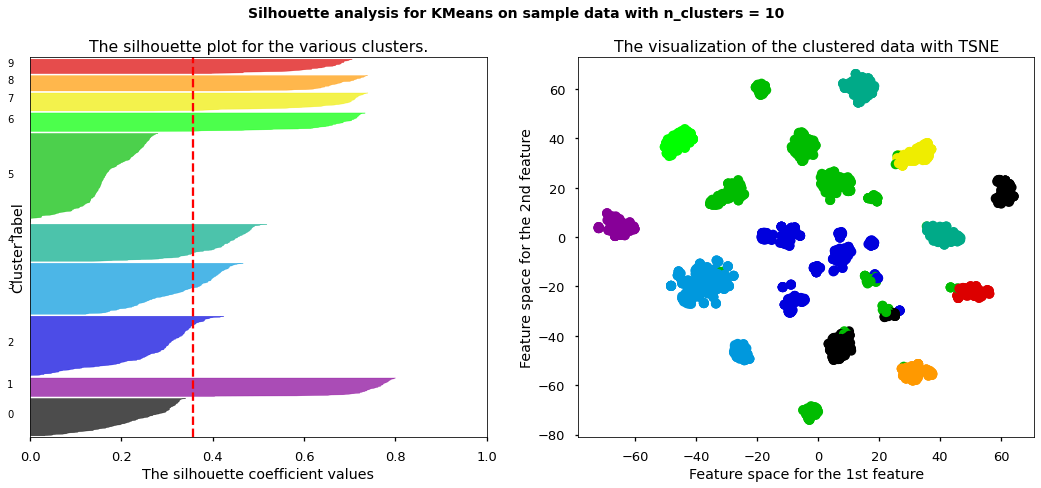

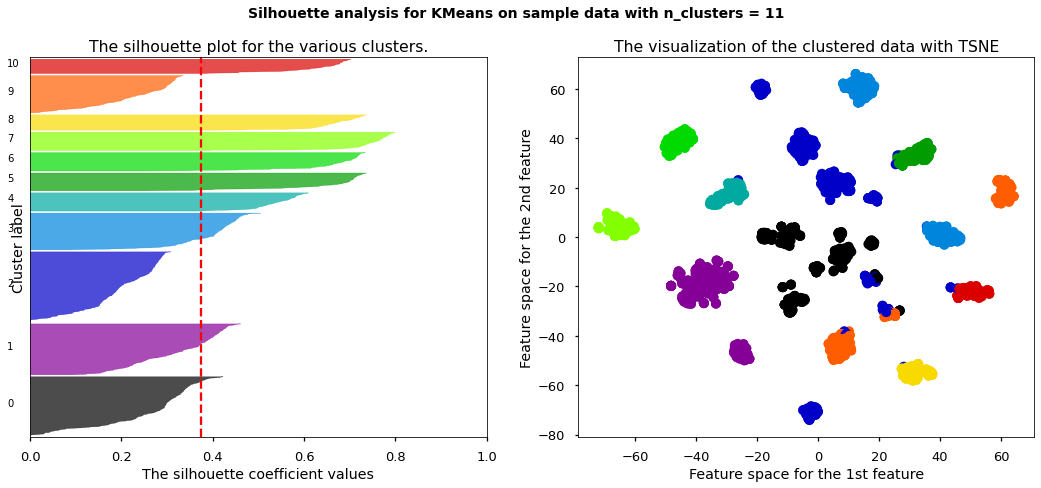

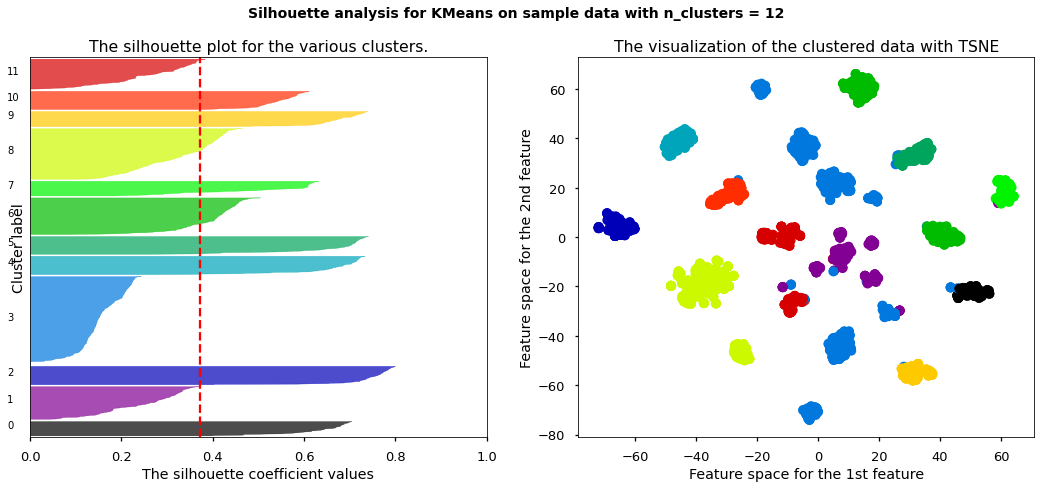

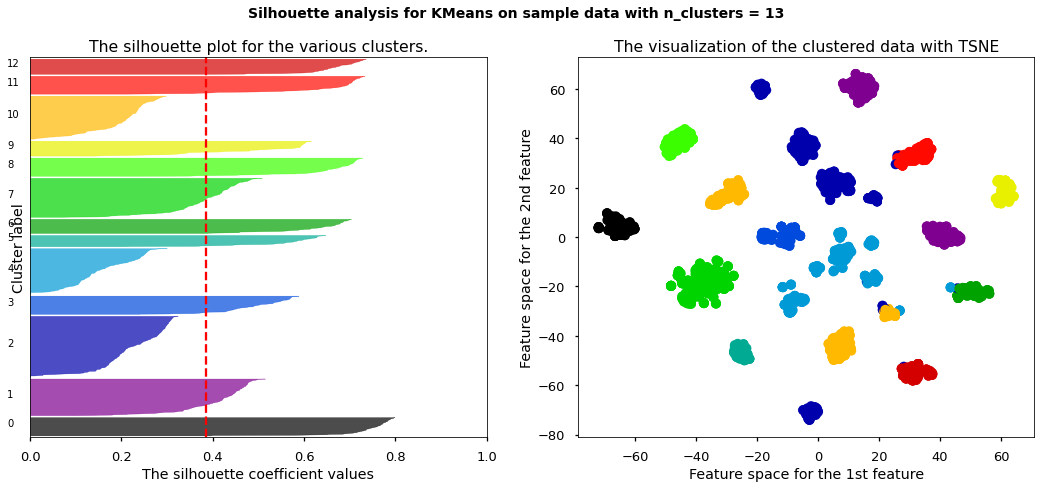

In [251]:
# Оценим критерий силуэтаvals
siluette_check(data=S, n_clusters=num_of_clusters, clusterer_name="KMeans")

Забавно, что при таком разбии, при 13 кластерах средний коэффициент сулэта получился больше, при этом даже визуально видно лучшее различие между кластерами

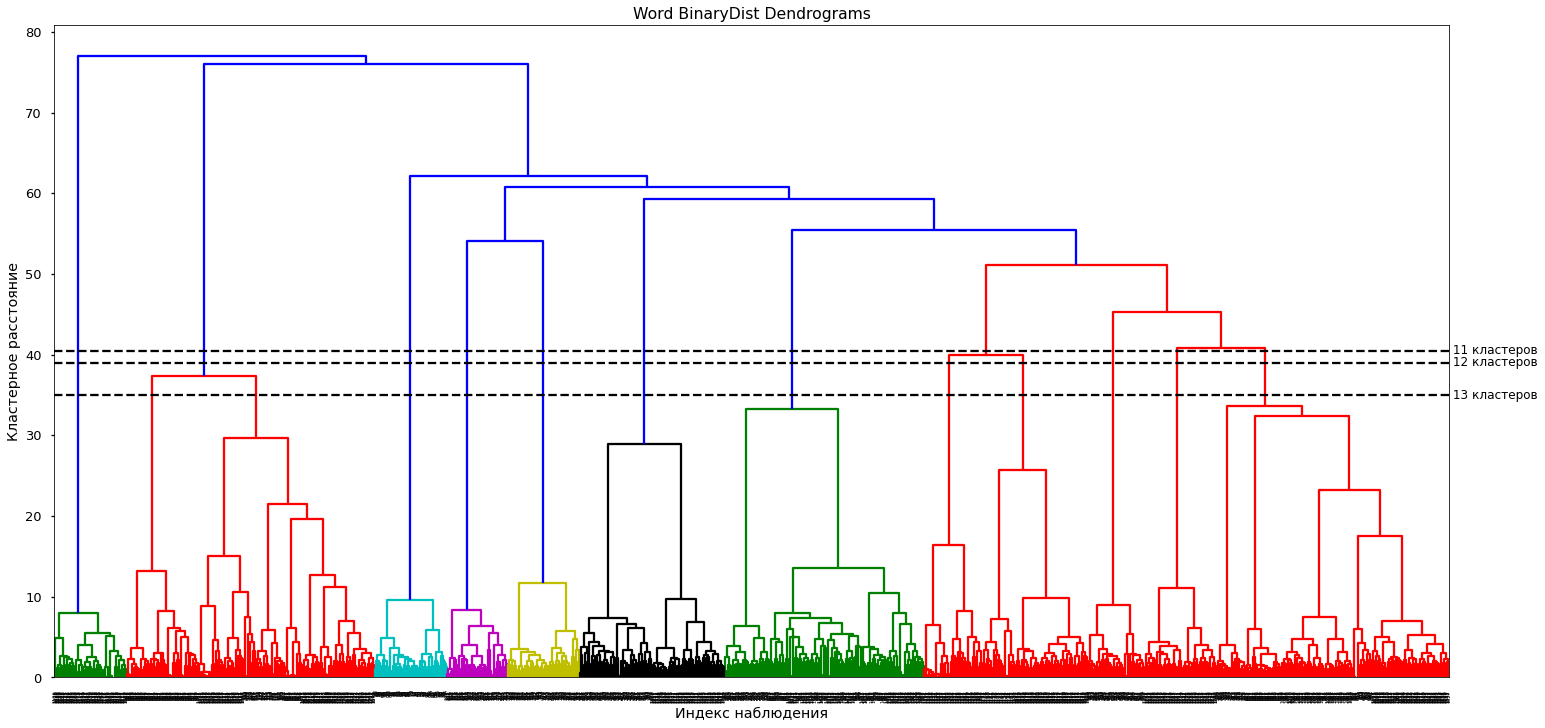

In [256]:
# Посмотрим еще с одного угла
# Оценим возможное количество кластеров при помощи дендрограмм
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(25, 12))
plt.title("Word BinaryDist Dendrograms")

# Метод связывания кластеров - метод Варда - выбирает и объединяет два
# кластера так, чтобы прирост дисперсии внутри кластеров был
# минимальным. Часто этот критерий приводит к получению кластеров
# относительно одинакового размера, что нам полностью удовлетворяет
dend = shc.dendrogram(shc.linkage(S, method='ward'))
ax = plt.gca()
bounds = ax.get_xbound()

plt.xlabel("Индекс наблюдения")
plt.ylabel("Кластерное расстояние")

ax.plot(bounds, [40.5, 40.5], '--', c='k')
ax.plot(bounds, [39, 39], '--', c='k')
ax.plot(bounds, [35, 35], '--', c='k')
ax.text(bounds[1], 40.5, ' 11 кластеров', va='center', fontdict={'size': 12})
ax.text(bounds[1], 39, ' 12 кластеров', va='center', fontdict={'size': 12})
ax.text(bounds[1], 35, ' 13 кластеров', va='center', fontdict={'size': 12})

plt.show()

In [257]:
# Инициализируем количество кластеров
num_of_clusters = 13

In [258]:
AGH_model = AgglomerativeClustering(n_clusters=num_of_clusters, affinity='euclidean', linkage='ward')
AGH_preds = AGH_model.fit_predict(S)

Counter({0: 322, 2: 276, 1: 243, 5: 200, 6: 145, 10: 100, 3: 100, 12: 100, 7: 100, 4: 99, 8: 84, 11: 82, 9: 79})


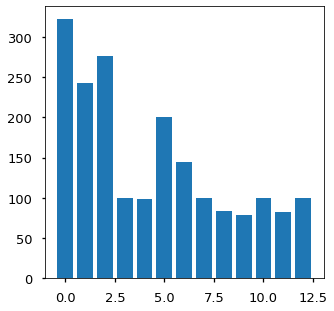

In [259]:
# Подсчитаем количество лейблов в каждом кластере
draw_counter_bar(AGH_preds)

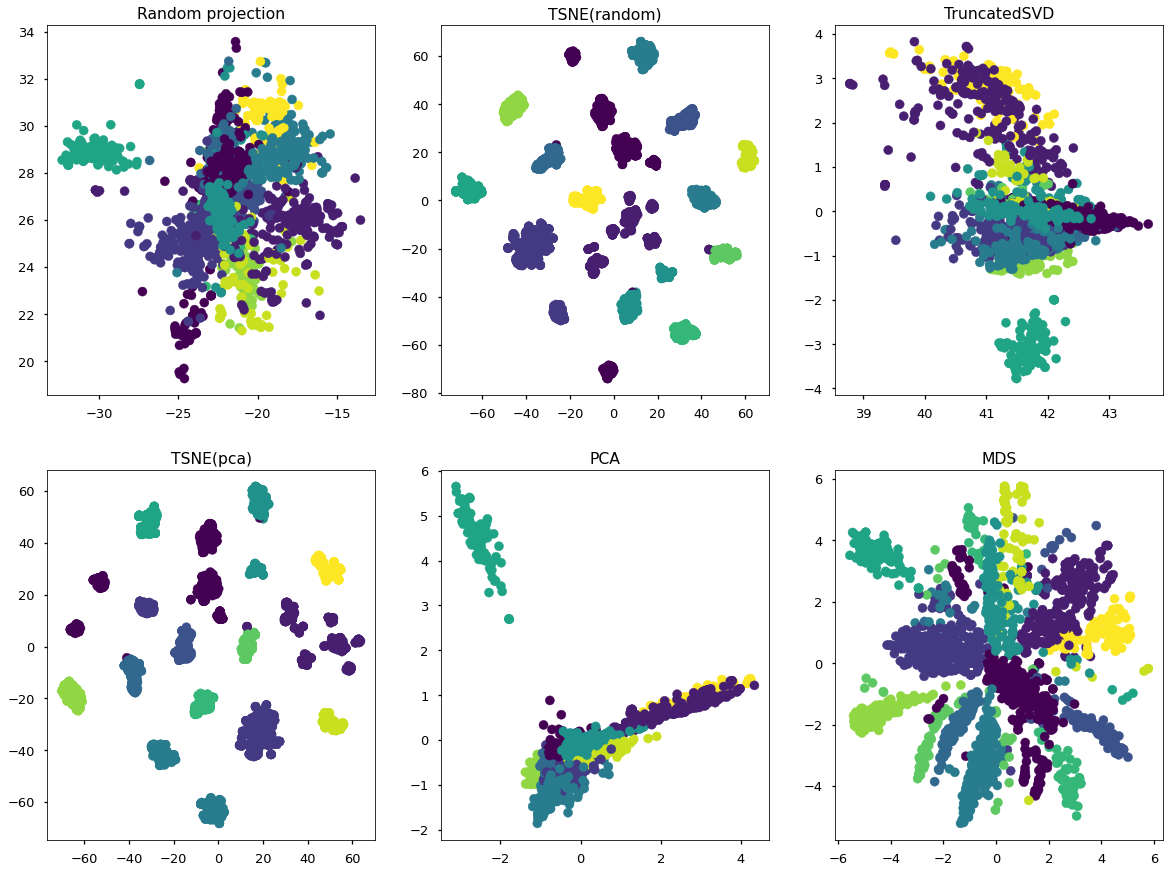

In [260]:
decrease_dimension(S, num_of_components, random_state, AGH_preds)

For n_clusters = 2 The average silhouette_score is : 0.28708226656727814
For n_clusters = 3 The average silhouette_score is : 0.17650395729432153
For n_clusters = 4 The average silhouette_score is : 0.21292230522560776
For n_clusters = 5 The average silhouette_score is : 0.24527959430034474
For n_clusters = 6 The average silhouette_score is : 0.25453773728283874
For n_clusters = 7 The average silhouette_score is : 0.27212023429145626
For n_clusters = 8 The average silhouette_score is : 0.30737626033109794
For n_clusters = 9 The average silhouette_score is : 0.33575444248534614
For n_clusters = 10 The average silhouette_score is : 0.359261899990169
For n_clusters = 11 The average silhouette_score is : 0.3779537369037384
For n_clusters = 12 The average silhouette_score is : 0.3940692469725433
For n_clusters = 13 The average silhouette_score is : 0.39839024528063055


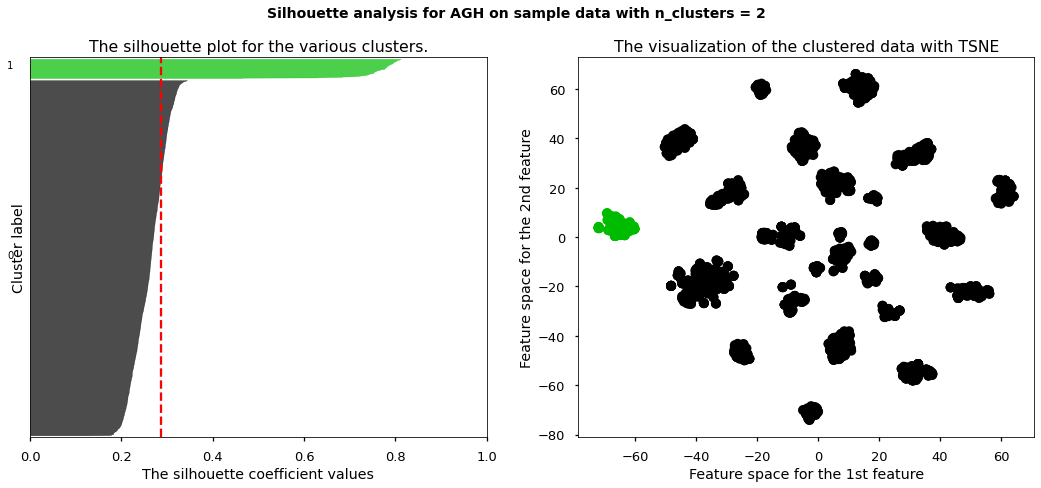

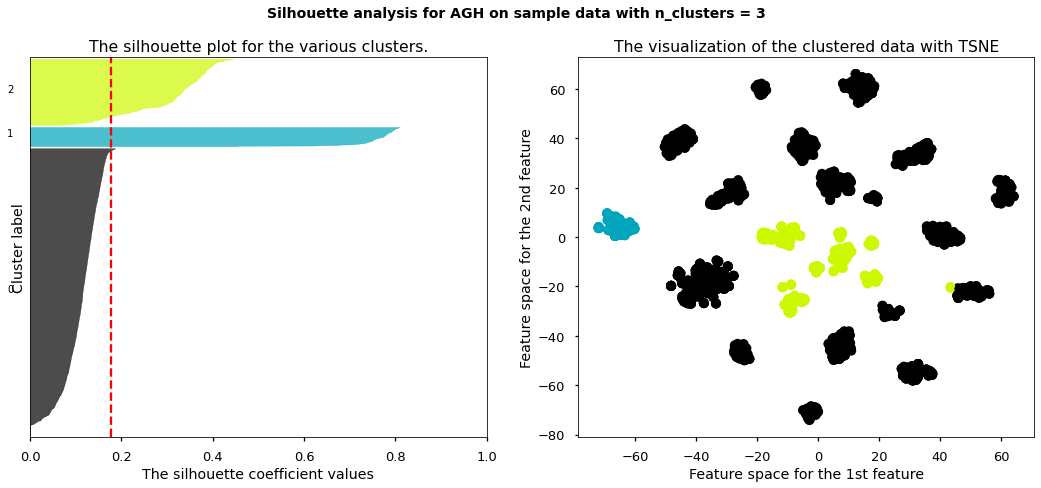

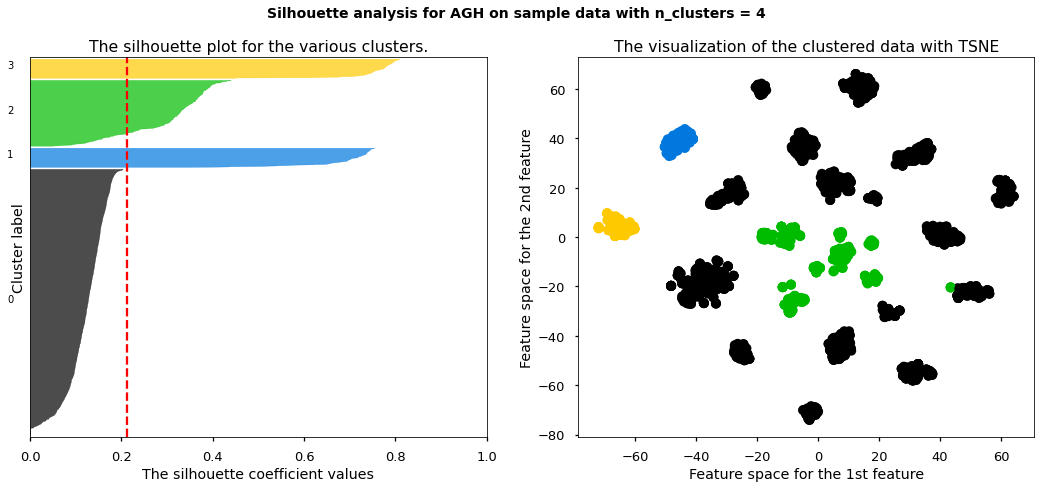

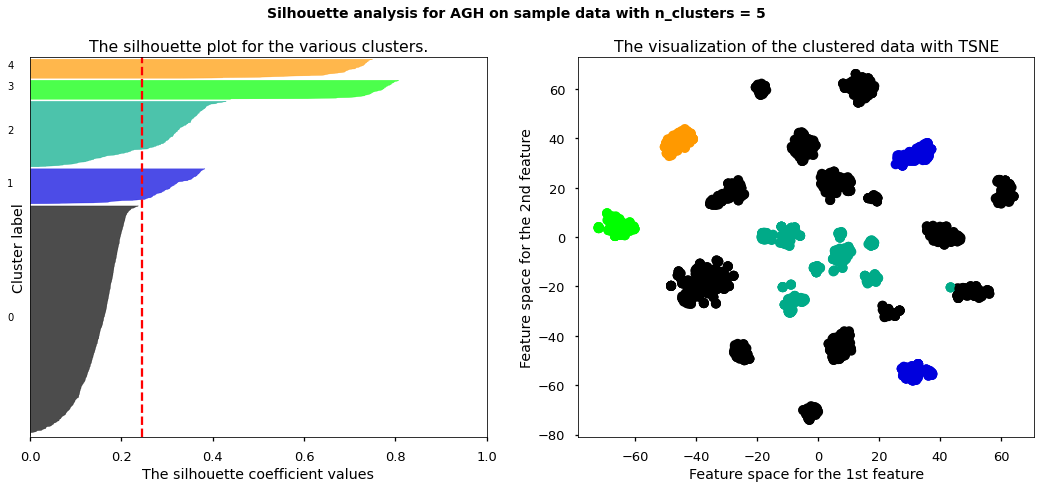

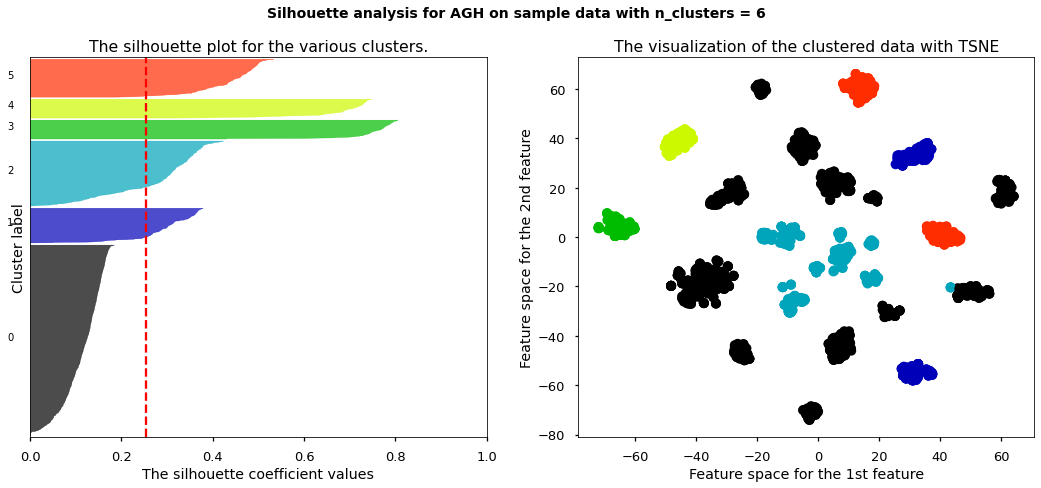

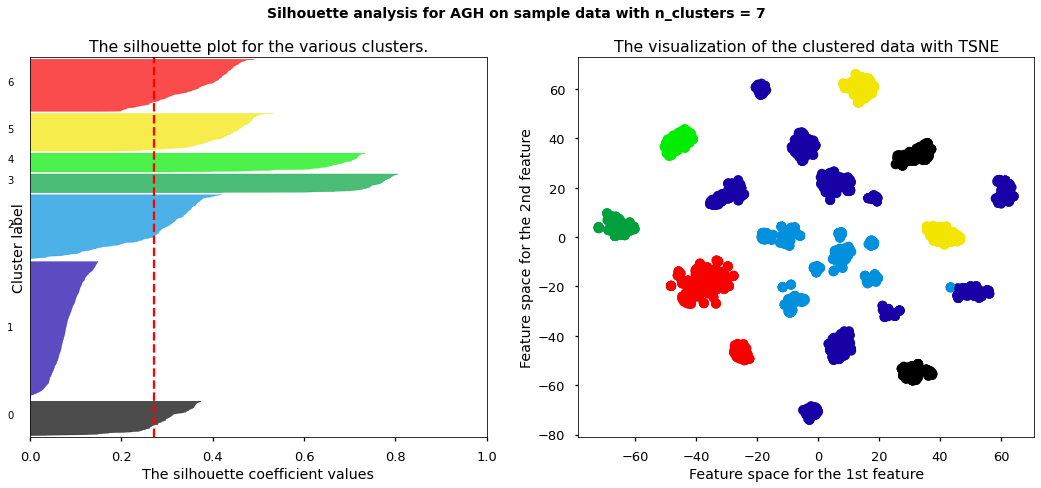

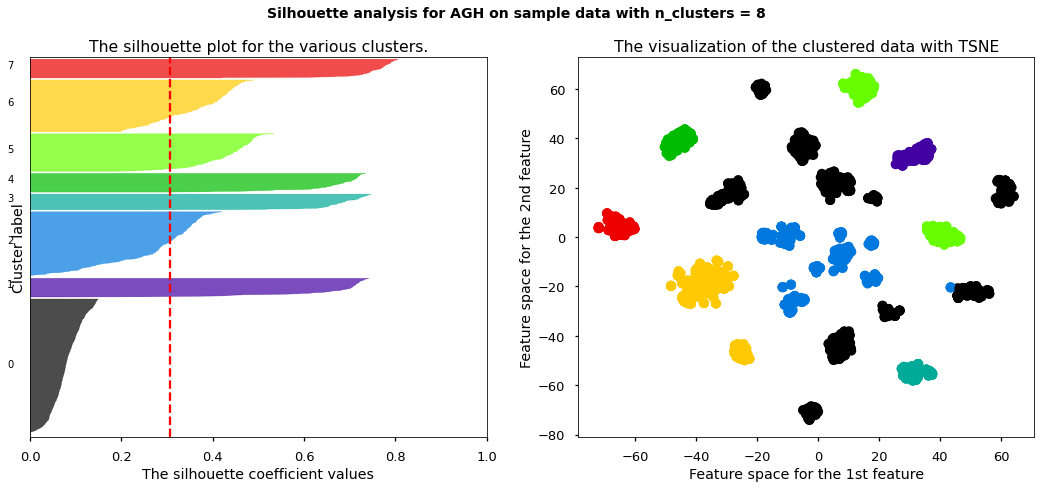

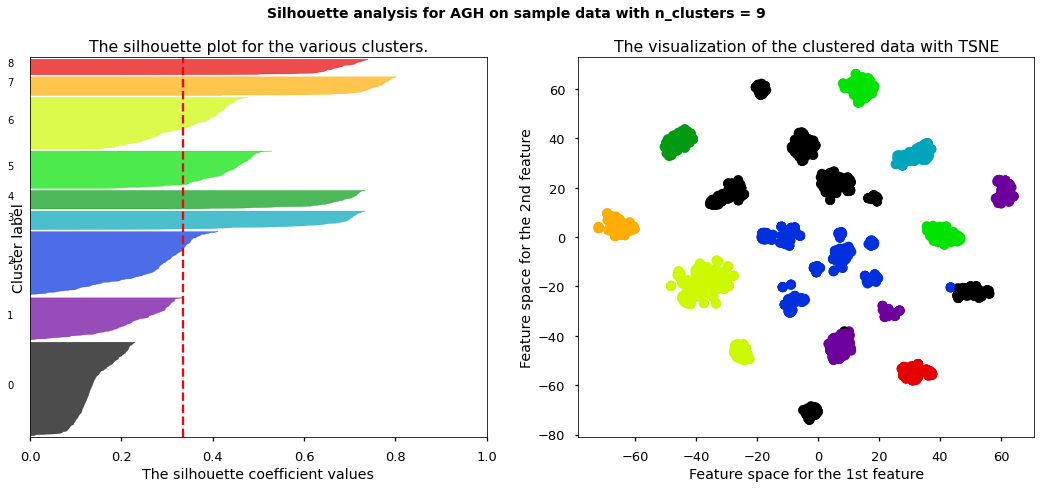

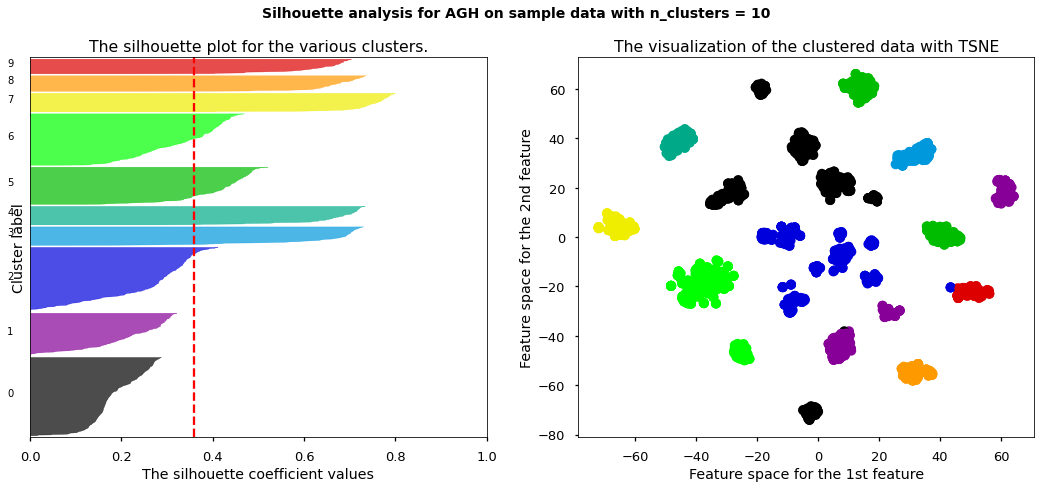

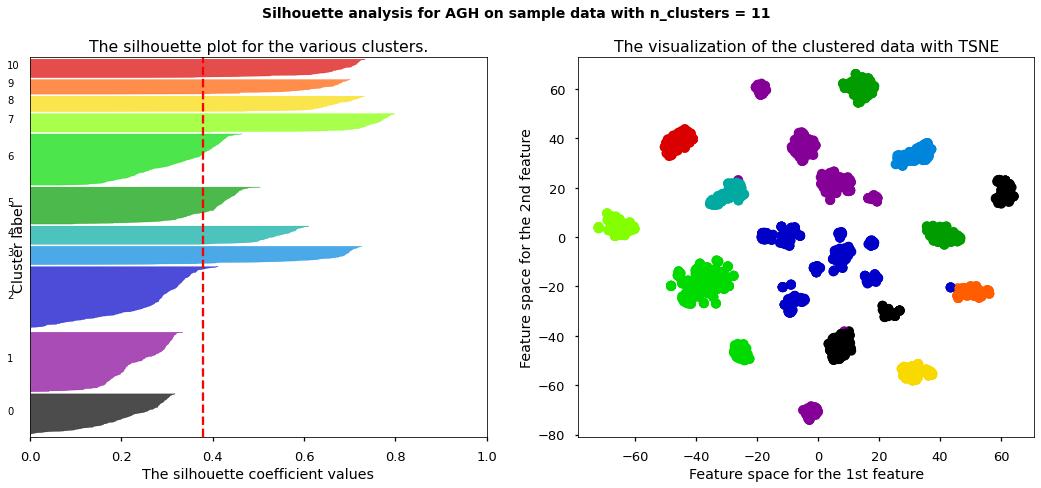

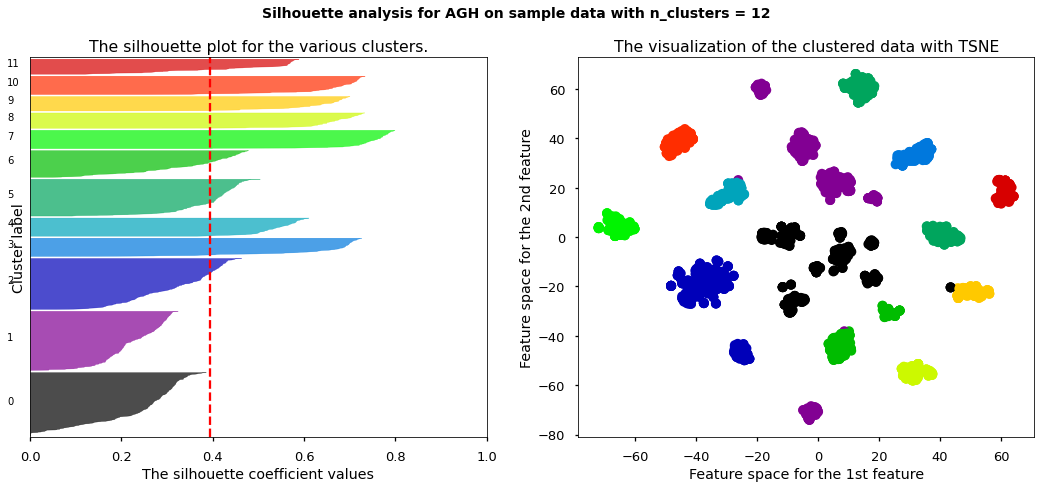

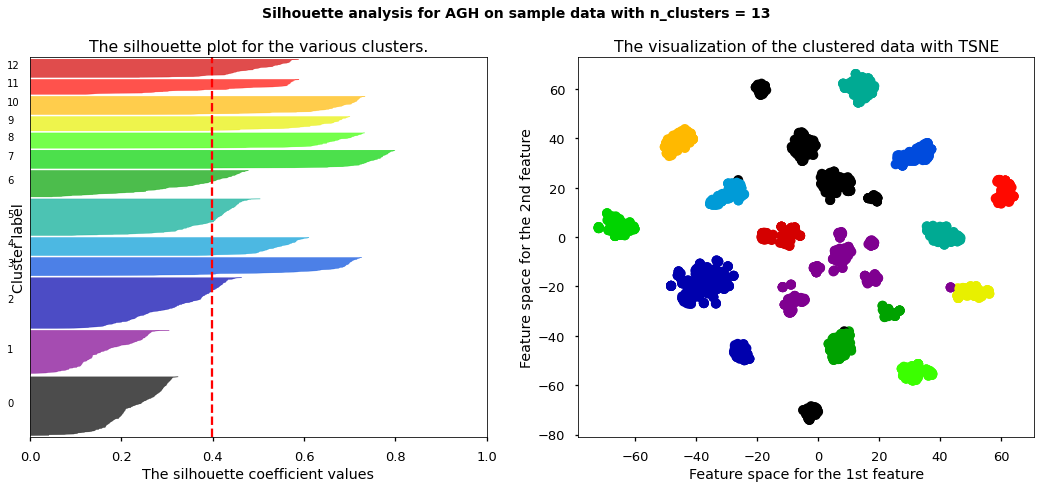

In [261]:
siluette_check(data=S, n_clusters=num_of_clusters, clusterer_name="AGH")

Наблюдаем тот же эффект и для кластерной агломеративной кластеризации. Те же 13 кластеров